In [1]:
#Import required libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import syft as sy
import sys
import pdb 
import math
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import torchvision.models as models
from random import shuffle
from torch.utils.data import SubsetRandomSampler

W1016 16:30:33.256397 184404 secure_random.py:26] Falling back to insecure randomness since the required custom op could not be found for the installed version of TensorFlow. Fix this by compiling custom ops. Missing file was 'c:\users\florian\appdata\local\programs\python\python37\lib\site-packages\tf_encrypted-0.5.9-py3.7.egg\tf_encrypted/operations/secure_random/secure_random_module_tf_1.15.0-rc3.so'
W1016 16:30:33.295397 184404 module_wrapper.py:139] From c:\users\florian\appdata\local\programs\python\python37\lib\site-packages\tf_encrypted-0.5.9-py3.7.egg\tf_encrypted\session.py:24: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.



In [2]:
torch.set_default_tensor_type(torch.cuda.FloatTensor)
use_cuda = True
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
device = torch.device("cuda" if use_cuda else "cpu")
batch_size = 10

# Creating workers

In [3]:
hook = sy.TorchHook(torch)  # <-- NEW: hook PyTorch ie add extra functionalities to support Federated Learning
alice = sy.VirtualWorker(hook, id="alice")  # <-- NEW: and alice
bob = sy.VirtualWorker(hook, id="bob")  # <-- NEW: define remote worker
#chalie = sy.VirtualWorker(hook, id="chalie")  # <-- NEW: define remote worker
#dave = sy.VirtualWorker(hook, id="dave")  # <-- NEW: define remote worker
#evelyn = sy.VirtualWorker(hook, id="evelyn")  # <-- NEW: define remote worker
#frank = sy.VirtualWorker(hook, id="frank")  # <-- NEW: define remote worker
#gustav = sy.VirtualWorker(hook, id="gustav")  # <-- NEW: define remote worker
#helmut = sy.VirtualWorker(hook, id="helmut")  # <-- NEW: define remote worker
#isabella = sy.VirtualWorker(hook, id="isabella")  # <-- NEW: define remote worker


fraudulin = sy.VirtualWorker(hook, id="fraudulin")
#fraudrich = sy.VirtualWorker(hook, id="fraudrich") 


compute_nodes = [alice, bob]
frauds = [fraudulin]

# Loading training & test datasets

In [4]:
data_transform = transforms.Compose([
        #transforms.RandomVerticalFlip(),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(224),
        transforms.ColorJitter(brightness=0.3,saturation=0.3,contrast=0.3),
        transforms.ToTensor(),                     
        transforms.Normalize(                     
            mean=[0.485, 0.456, 0.406],               
            std=[0.229, 0.224, 0.225]                  
        )])

trafficsign = datasets.ImageFolder(root = 
                             'C:\\Users\Florian\\Desktop\\Datensätze_ready\\yalefaces_reworked',
                             transform=data_transform)

# split into train and test dataset
train_split = 0.8
dataset_size = len(trafficsign) #for testing purpose set to 1000 - else set: len(trafficsign) 
indices = list(range(dataset_size))
split = int(np.floor(train_split * dataset_size))
if 1 :
    np.random.seed(1337)
    np.random.shuffle(indices)
train_indices, test_indices = indices[:split], indices[split:]


dataset_loader = torch.utils.data.DataLoader(trafficsign,
                                             batch_size=batch_size,
                                             sampler=SubsetRandomSampler(train_indices),
                                              **kwargs)

test_loader = torch.utils.data.DataLoader(trafficsign,
                                             batch_size=batch_size,
                                             sampler=SubsetRandomSampler(test_indices),
                                              **kwargs)

# Load backdoor dataset

In [5]:
backdoored = datasets.ImageFolder(root = 
                             'C:\\Users\Florian\\Desktop\\Datensätze_ready\\yalefaces_reworked_backdoors',
                             transform=data_transform)

# shorten for testing reasons
size = len(backdoored) #for testing purpose set to 1000 - else set: len(backdoored) 
indices = list(range(len(backdoored)))
if 1 :
    np.random.seed(1337)
    np.random.shuffle(indices)
usedIndices = indices[:size]

backdoored.classes = '001' #<-- set all backdoors to a specific (wrong) class

dataset_loader_backdoored = torch.utils.data.DataLoader(backdoored,
                                             batch_size=batch_size, 
                                             sampler=SubsetRandomSampler(usedIndices),
                                              **kwargs)

# Visualize some training data

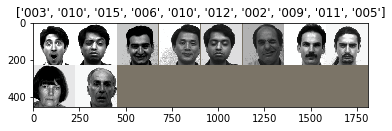

In [6]:
#Let’s visualize a few training images so as to understand the data augmentations.

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

class_names = trafficsign.classes
# Get a batch of training data
inputs, classes = next(iter(dataset_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# Neural Network Structure

In [7]:
class Net(nn.Module):
    def __init__(self, num_classes=len(class_names)):
        super(Net, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(-1, 256 * 6 * 6)
        x = self.classifier(x)
        return x
    
#http://publications.lib.chalmers.se/records/fulltext/255863/255863.pdf


# Send dataset to clients

In [8]:
train_distributed_dataset = []
train_distributed_dataset_backdoor = []

#normal clients
for batch_idx, (data,target) in enumerate(dataset_loader):
            data_append = data.send(compute_nodes[batch_idx % len(compute_nodes)], inplace = True)
            target_append = target.send(compute_nodes[batch_idx % len(compute_nodes)], inplace = True)
            train_distributed_dataset.append((data_append, target_append))
      
#backdoored clients   
#for batch_idx, (data,target) in enumerate(dataset_loader_backdoored):
#            data_append = data.send(frauds[batch_idx % len(frauds)], inplace = True)
#            target_append = target.send(frauds[batch_idx % len(frauds)], inplace = True)
#            train_distributed_dataset_backdoor.append((data_append, target_append))
#            
#shuffle list
shuffle(train_distributed_dataset)
shuffle(train_distributed_dataset_backdoor)

#train_distributed_dataset[0]

# Training Function

In [9]:
def train(epoch):
    model.train()
    #backdoor training in the beginning
#    for batch_idx, (data,target) in enumerate(train_distributed_dataset_backdoor):        
#        model.send(data.location) # 0) send the model to the right location
#        data, target = data.to(device), target.to(device)
#        optimizer.zero_grad() # 1) erase previous gradients (if they exist)
#        #import pdb; pdb.set_trace()
#        output = model(data)  # 2) make a prediction
#        loss = F.nll_loss(output, target) # 3) calculate how much we missed
#        loss.backward() # 4) figure out which weights caused us to miss
#        optimizer.step() # 5) change those weights
#        model.get() # 6) get model (with gradients)
#            
#        #if batch_idx % 100 == 0:
#        loss = loss.get() # <-- NEW: get the loss back
#        print('BACKDOOR: Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
#                epoch, batch_idx * batch_size, len(train_distributed_dataset_backdoor) * batch_size,
#                100. * batch_idx / len(train_distributed_dataset_backdoor), loss.item()))
    
    #normal training
    for batch_idx, (data,target) in enumerate(train_distributed_dataset):        
        model.send(data.location) # 0) send the model to the right location
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad() # 1) erase previous gradients (if they exist)
        #import pdb; pdb.set_trace()
        output = model(data)  # 2) make a prediction
        loss = F.cross_entropy(output, target) # 3) calculate how much we missed
        loss.backward() # 4) figure out which weights caused us to miss
        optimizer.step() # 5) change those weights
        model.get() # 6) get model (with gradients)
            
        #if batch_idx % 300 == 0:
        loss = loss.get() # <-- NEW: get the loss back
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * batch_size, len(train_distributed_dataset) * batch_size,
                100. * batch_idx / len(train_distributed_dataset), loss.item()))

# Test Function

In [10]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(1, keepdim=True) # get the index of the max log-probability 
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_indices)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_indices),
        100. * correct / len(test_indices)))
    
    #confusion matrix
    nb_classes = len(class_names)
    confusion_matrix = torch.zeros(nb_classes, nb_classes)
    with torch.no_grad():
        for i, (inputs, classes) in enumerate(test_loader):
            inputs = inputs.to(device)
            classes = classes.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for t, p in zip(classes.view(-1), preds.view(-1)):
                    confusion_matrix[t.long(), p.long()] += 1
    print(confusion_matrix)
    # print(confusion_matrix.diag()/confusion_matrix.sum(1)) per class accuracy
    return test_loss

# Run everyting

In [11]:
#helper function for learning rate
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [12]:
import torchvision.models as models

model = Net().to(device)

# stopped at:
#model.load_state_dict(torch.load("newfaces_alexnet_224x224_augmented35.pt"))
optimizer = optim.SGD(model.parameters(), lr=0.01)

#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')


#set learing rate to value
#for a in range(1,31):
#    scheduler.step()

#RUN training
for epoch in range(1, 500):
    print(get_lr(optimizer))
    train(epoch)
    if epoch % 10 == 0:
        torch.save(model.state_dict(), ("newfaces_alexnet_224x224_augmented" + str(epoch) + ".pt"))
    test_loss = test(model, device, test_loader)
    #scheduler.step(test_loss)



0.01
Train Epoch: 1 [0/90 (0%)]	Loss: 2.567455
Train Epoch: 1 [10/90 (11%)]	Loss: 2.568269
Train Epoch: 1 [20/90 (22%)]	Loss: 2.569427
Train Epoch: 1 [30/90 (33%)]	Loss: 2.562233
Train Epoch: 1 [40/90 (44%)]	Loss: 2.566668
Train Epoch: 1 [50/90 (56%)]	Loss: 2.559444
Train Epoch: 1 [60/90 (67%)]	Loss: 2.568007
Train Epoch: 1 [70/90 (78%)]	Loss: 2.556159
Train Epoch: 1 [80/90 (89%)]	Loss: 2.559725

Test set: Average loss: 2.5681, Accuracy: 1/21 (5%)

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.

        [0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
0.01
Train Epoch: 8 [0/90 (0%)]	Loss: 2.581028
Train Epoch: 8 [10/90 (11%)]	Loss: 2.563941
Train Epoch: 8 [20/90 (22%)]	Loss: 2.558786
Train Epoch: 8 [30/90 (33%)]	Loss: 2.553795
Train Epoch: 8 [40/90 (44%)]	Loss: 2.523843
Train Epoch: 8 [50/90 (56%)]	Loss: 2.552046
Train Epoch: 8 [60/90 (67%)]	Loss: 2.568906
Train Epoch: 8 [70/90 (78%)]	Loss: 2.548479
Train Epoch: 8 [80/90 (89%)]	Loss: 2.559466

Test set: Average loss: 2.5765, Accuracy: 1/21 (5%)

tensor([[0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0

        [0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
0.01
Train Epoch: 15 [0/90 (0%)]	Loss: 2.593675
Train Epoch: 15 [10/90 (11%)]	Loss: 2.557310
Train Epoch: 15 [20/90 (22%)]	Loss: 2.548322
Train Epoch: 15 [30/90 (33%)]	Loss: 2.541314
Train Epoch: 15 [40/90 (44%)]	Loss: 2.477158
Train Epoch: 15 [50/90 (56%)]	Loss: 2.542810
Train Epoch: 15 [60/90 (67%)]	Loss: 2.571685
Train Epoch: 15 [70/90 (78%)]	Loss: 2.535715
Train Epoch: 15 [80/90 (89%)]	Loss: 2.556672

Test set: Average loss: 2.5833, Accuracy: 1/21 (5%)

tensor([[0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 

        [0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
0.01
Train Epoch: 22 [0/90 (0%)]	Loss: 2.610657
Train Epoch: 22 [10/90 (11%)]	Loss: 2.548877
Train Epoch: 22 [20/90 (22%)]	Loss: 2.533879
Train Epoch: 22 [30/90 (33%)]	Loss: 2.523245
Train Epoch: 22 [40/90 (44%)]	Loss: 2.417642
Train Epoch: 22 [50/90 (56%)]	Loss: 2.528598
Train Epoch: 22 [60/90 (67%)]	Loss: 2.573372
Train Epoch: 22 [70/90 (78%)]	Loss: 2.514629
Train Epoch: 22 [80/90 (89%)]	Loss: 2.545228

Test set: Average loss: 2.5998, Accuracy: 1/21 (5%)

tensor([[0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 

        [0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
0.01
Train Epoch: 29 [0/90 (0%)]	Loss: 2.657942
Train Epoch: 29 [10/90 (11%)]	Loss: 2.530098
Train Epoch: 29 [20/90 (22%)]	Loss: 2.494430
Train Epoch: 29 [30/90 (33%)]	Loss: 2.468738
Train Epoch: 29 [40/90 (44%)]	Loss: 2.271067
Train Epoch: 29 [50/90 (56%)]	Loss: 2.482260
Train Epoch: 29 [60/90 (67%)]	Loss: 2.571431
Train Epoch: 29 [70/90 (78%)]	Loss: 2.436426
Train Epoch: 29 [80/90 (89%)]	Loss: 2.470413

Test set: Average loss: 2.6548, Accuracy: 3/21 (14%)

tensor([[0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.,

        [0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
0.01
Train Epoch: 36 [0/90 (0%)]	Loss: 2.508637
Train Epoch: 36 [10/90 (11%)]	Loss: 2.163149
Train Epoch: 36 [20/90 (22%)]	Loss: 2.010265
Train Epoch: 36 [30/90 (33%)]	Loss: 1.928103
Train Epoch: 36 [40/90 (44%)]	Loss: 1.272538
Train Epoch: 36 [50/90 (56%)]	Loss: 2.281326
Train Epoch: 36 [60/90 (67%)]	Loss: 2.375598
Train Epoch: 36 [70/90 (78%)]	Loss: 1.925548
Train Epoch: 36 [80/90 (89%)]	Loss: 1.678620

Test set: Average loss: 2.6882, Accuracy: 1/21 (5%)

tensor([[0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 

        [1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
0.01
Train Epoch: 43 [0/90 (0%)]	Loss: 1.494141
Train Epoch: 43 [10/90 (11%)]	Loss: 1.002428
Train Epoch: 43 [20/90 (22%)]	Loss: 0.499649
Train Epoch: 43 [30/90 (33%)]	Loss: 1.069449
Train Epoch: 43 [40/90 (44%)]	Loss: 0.104580
Train Epoch: 43 [50/90 (56%)]	Loss: 0.938845
Train Epoch: 43 [60/90 (67%)]	Loss: 0.787347
Train Epoch: 43 [70/90 (78%)]	Loss: 0.864112
Train Epoch: 43 [80/90 (89%)]	Loss: 0.841168

Test set: Average loss: 3.3274, Accuracy: 8/21 (38%)

tensor([[1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1.,

        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.]])
0.01
Train Epoch: 50 [0/90 (0%)]	Loss: 1.313269
Train Epoch: 50 [10/90 (11%)]	Loss: 0.866489
Train Epoch: 50 [20/90 (22%)]	Loss: 0.711494
Train Epoch: 50 [30/90 (33%)]	Loss: 0.733717
Train Epoch: 50 [40/90 (44%)]	Loss: 0.056511
Train Epoch: 50 [50/90 (56%)]	Loss: 0.731433
Train Epoch: 50 [60/90 (67%)]	Loss: 0.586560
Train Epoch: 50 [70/90 (78%)]	Loss: 0.545820
Train Epoch: 50 [80/90 (89%)]	Loss: 0.218503

Test set: Average loss: 1.1049, Accuracy: 16/21 (76%)

tensor([[2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1.

KeyboardInterrupt: 

In [ ]:
len(class_names)

In [ ]:
torch.cuda.empty_cache()